**Table of contents**<a id='toc0_'></a>    
- [Univariate analysis](#toc1_1_1_1_)    
    - [Multivariate](#toc1_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Visualization and Analysis Plan

1. Univariate

- Plot 1 stock index based on Close
 
- Daily Return 

- Distribution of Close Price

- Calculate the technical indicators: MACD, RSI, Boilinger Band, MFI, Stochastic and draw the candlestick to see the overview of the trend
and the related indicators

- Time series based analysis:
    + Stationarity
    + Autocorrelation
    + Decomposition to see the trends (seasonal decomposition)
    + Also combine with evaluation metrics like Entropy to see the nature of data 
    + Wavelet transform (global spectrum)
    + HHT (hilbert spectrum)

2. Multivariate
- Raw plot for comparisons
- Correlation and pairplot

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf

#Time series decomposition and forecasting prep
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss

#Stationarity test
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

#Smoothing
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.signal import savgol_filter
import pywt # wavelet transform
from scipy.signal import stft #short time fourier transform, default frourier transform is already in numpy
from PyEMD.EMD import EMD #EMD
from PyEMD import EEMD #EEMD
from numpy.fft import fft, ifft, fftshift, ifftshift #VMD

# Additional
from scipy.signal import hilbert

#setup system path for modular import
import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.utils.processing.denoising import Dimensional_Denoise
from src.utils.processing.extract_stock_index import extract_index
from src.utils.processing.feature_extraction import Feature

In [2]:
feature = Feature()

In [3]:
df_MSFT = extract_index('MSFT')

df_MSFT = feature.apply_all(df = df_MSFT)

#### <a id='toc1_1_1_1_'></a>[Univariate analysis](#toc0_)

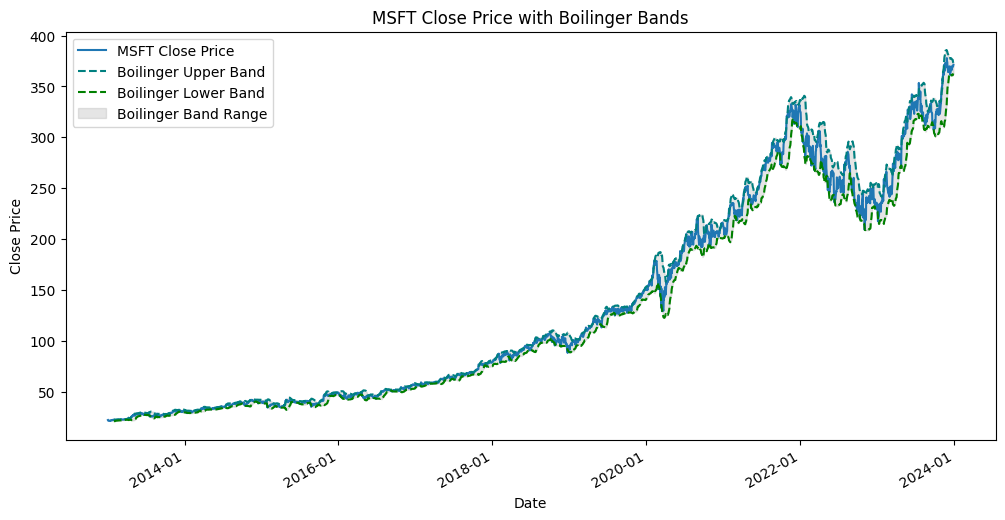

In [6]:
# Also added Boilinger Bands
plt.figure(figsize=(12, 6))
plt.plot(df_MSFT['Date'], df_MSFT['Close'], label='MSFT Close Price')
plt.plot(df_MSFT['Date'], df_MSFT['boilinger_up'], label='Boilinger Upper Band', linestyle='--', color='teal')
plt.plot(df_MSFT['Date'], df_MSFT['boilinger_down'], label='Boilinger Lower Band', linestyle='--', color='green')

# Add shaded area between bands
plt.fill_between(
    df_MSFT['Date'],
    df_MSFT['boilinger_up'],
    df_MSFT['boilinger_down'],
    color='gray',
    alpha=0.2,
    label='Boilinger Band Range'
)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('MSFT Close Price with Boilinger Bands')
plt.legend()

# Format x-axis as dates using mdates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels

plt.show()
# ...existing code...

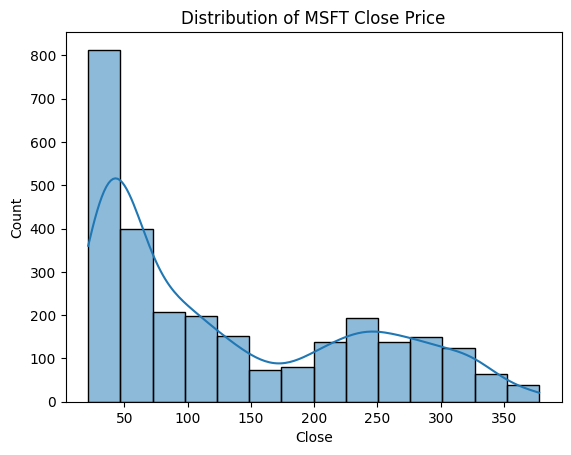

In [ ]:
sns.histplot(df_MSFT['Close'], kde=True)
plt.title('Distribution of MSFT Close Price')
plt.show()

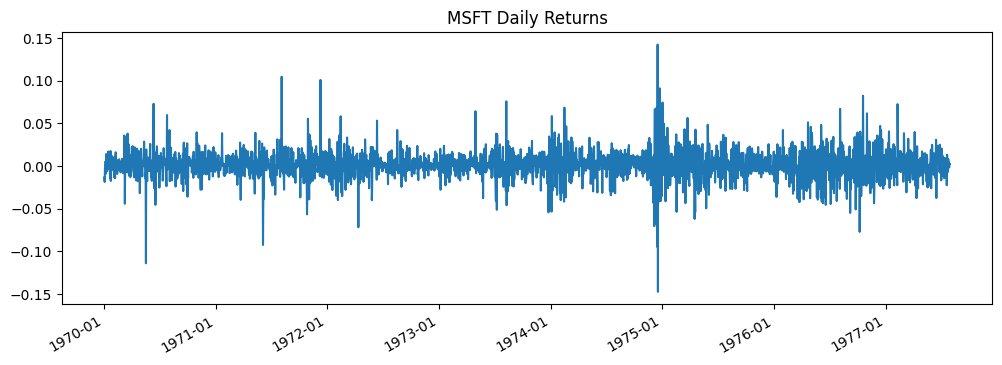

In [11]:
df_MSFT['Return'] = df_MSFT['Close'].pct_change()
plt.figure(figsize=(12, 4))
plt.plot(df_MSFT['Date'], df_MSFT['Return'])
plt.title('MSFT Daily Returns')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Auto-rotate date labels


plt.show()

d:\Study\Setup\anaconda\config\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


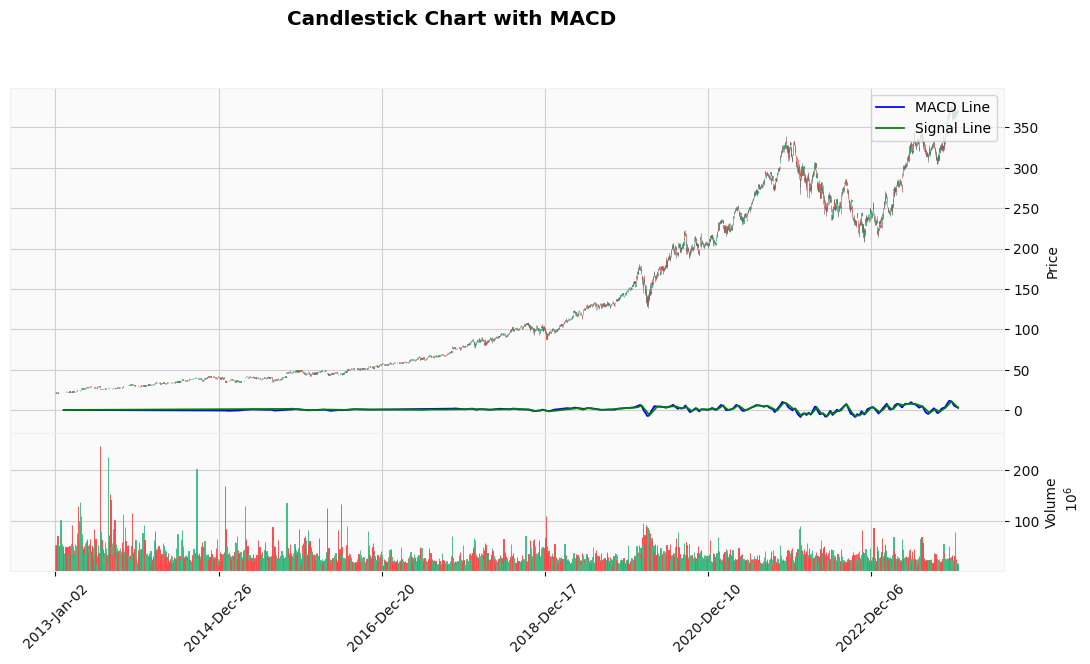

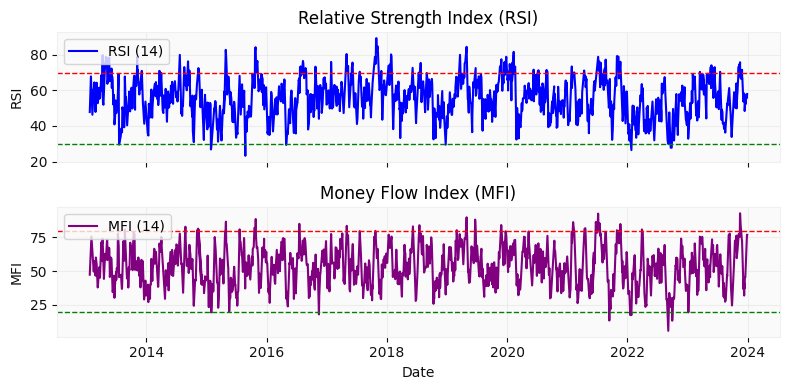

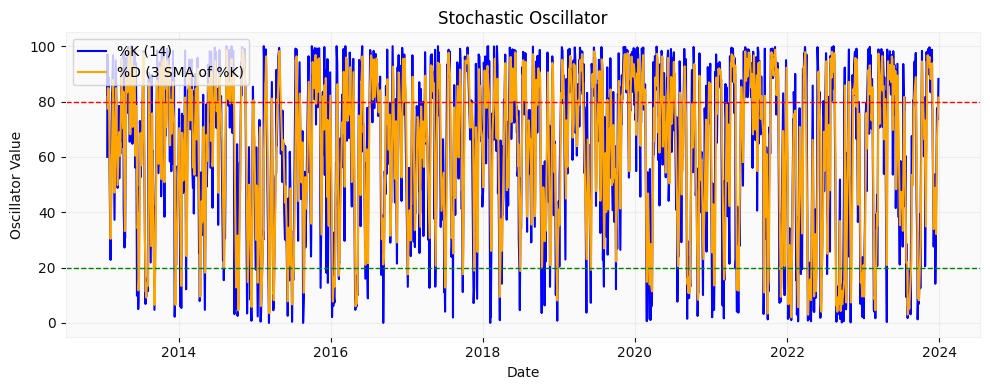

In [8]:
df_MSFT.index = df_MSFT['Date']

## 1. For the MACD and Signal Line on the candlestick chart
apds = [
    mpf.make_addplot(df_MSFT['MACD'], color='blue', label='MACD Line'),
    mpf.make_addplot(df_MSFT['Signal_Line'], color='green', label='Signal Line')
]

## 2. Plot candlestick chart with volume
mpf.plot(
    df_MSFT,
    type='candle',
    style='yahoo',
    volume=True,
    addplot=apds,
    title="Candlestick Chart with MACD",
    ylabel="Price",
    ylabel_lower="Volume",
    figratio=(8,4),
    figscale=1.2
)

## 3. Plot RSI and MFI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4), sharex=True)

ax1.plot(df_MSFT['Date'], df_MSFT['RSI'], label='RSI (14)', color='blue')
ax1.axhline(70, color='red', linestyle='--', linewidth=1)   # overbought
ax1.axhline(30, color='green', linestyle='--', linewidth=1) # oversold
ax1.set_title("Relative Strength Index (RSI)")
ax1.set_ylabel("RSI")
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)

ax2.plot(df_MSFT['Date'], df_MSFT['MFI'], label='MFI (14)', color='purple')
ax2.axhline(80, color='red', linestyle='--', linewidth=1)   # overbought
ax2.axhline(20, color='green', linestyle='--', linewidth=1) # oversold
ax2.set_title("Money Flow Index (MFI)")
ax2.set_ylabel("MFI")
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)

# Shared x-axis (Date)
plt.xlabel("Date")
plt.tight_layout()
plt.show()

## 4. Plot Stochastic Oscillator
plt.figure(figsize=(10,4))

plt.plot(df_MSFT['Date'], df_MSFT['%K'], label='%K (14)', color='blue')
plt.plot(df_MSFT['Date'], df_MSFT['%D'], label='%D (3 SMA of %K)', color='orange')

# Overbought / Oversold lines
plt.axhline(80, color='red', linestyle='--', linewidth=1)
plt.axhline(20, color='green', linestyle='--', linewidth=1)

plt.title("Stochastic Oscillator")
plt.ylabel("Oscillator Value")
plt.xlabel("Date")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Time Series based Analysis

In [ ]:
## The Data Stationarity and Potential Differencing

result = adfuller(temp[col].dropna())

## <a id='toc1_1_2_'></a>[Multivariate](#toc0_)

In [19]:
df_INTC = extract_index('INTC')
df_IBM = extract_index('IBM')

df_multi = df_MSFT[['Date', 'Close']].rename(columns={'Close': 'MSFT_Close'})
df_multi = df_multi.merge(df_INTC[['Date', 'Close']].rename(columns={'Close': 'INTC_Close'}), on='Date')
df_multi = df_multi.merge(df_IBM[['Date', 'Close']].rename(columns={'Close': 'IBM_Close'}), on='Date')

In [20]:
df_multi

,Date,MSFT_Close,INTC_Close,IBM_Close
0,2013-01-02,22.284512,15.289294,114.485031
1,2013-01-03,21.985987,15.246391,113.855286
2,2013-01-04,21.574501,15.131964,113.108963
3,2013-01-07,21.534155,15.196331,112.613365
4,2013-01-08,21.421202,15.081916,112.455910
...,...,...,...,...
2763,2023-12-22,369.767853,47.365639,153.382904
2764,2023-12-26,369.846893,49.832600,154.395126
2765,2023-12-27,369.264465,50.089161,154.631607
2766,2023-12-28,370.458923,49.724056,154.905930


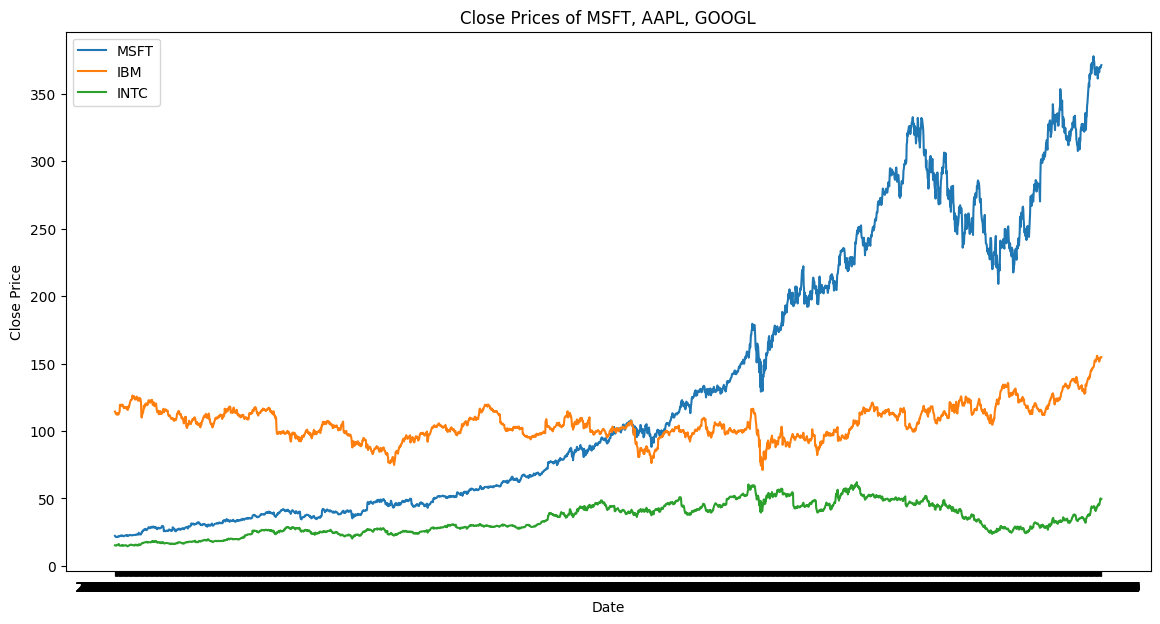

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(df_multi['Date'], df_multi['MSFT_Close'], label='MSFT')
plt.plot(df_multi['Date'], df_multi['IBM_Close'], label='IBM')
plt.plot(df_multi['Date'], df_multi['INTC_Close'], label='INTC')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices of MSFT, AAPL, GOOGL')
plt.legend()
plt.show()